Bambi is the project I dedicate the vast majority of my open-source development time. My goal is to make it a little better every time I push to the main branch. Lately I've been working to expand the class of models that Bambi supports. Until now, Bambi supported Generalized Linear Mixed Models (GLMMs). After the latest changes[^latest_changes] Bambi supports a wider class known as Generalized Linear Mixed Models for Location, Scale, and Shape. I also like the terminology used in [brms](https://mc-stan.org/users/interfaces/brms), Distributional Models.

The new additions to the library allow us to work with more flexible custom model families in an easier way. The question is: How to create a custom family in Bambi?

## Imports

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from bambi.plots import plot_cap
from matplotlib.lines import Line2D
from scipy.special import expit

## The Zero-Inflated Poisson distribution

I'm going to use the Zero-Inflated Poisson distribution to demonstrate how to add a custom family in Bambi. This distribution applies to random variables that show an excess of zeros  when describing the number of events that occur in a certain space or time period. 

Quoting Wikipedia [^zip_wikipedia] _"The zero-inflated Poisson (ZIP) model mixes two zero generating processes. The first process generates zeros. The second process is governed by a Poisson distribution that generates counts, some of which may be zero"._ The result is a mixture distribution that can be described as follows:


$$
\begin{array}{ll}
P(Y = 0) = (1 - \psi) + \psi e^{-\mu} \\
P(Y = y_i) = \displaystyle \psi \frac{e^{-\mu}\mu^y_i}{y_i!} & \text{if } y_i=1,2,3,\ldots
\end{array}
$$

Where 

* $y_i$ is the outcome, a non-negative integer
* $\mu$ is the mean of the Poisson process, $\mu \ge 0$ 
* $\psi$ is the probability of the Poisson process, $0 < \psi < 1$

The mean is $\psi\mu$ and the variance is $\displaystyle \mu + \frac{1-\psi}{\psi}\mu^2$.

## The ZIP Regression model

We have a response variable $Y$, which represents a count in a given space or time, and $p$ predictors $X_1, \cdots, X_p$. In the most general formulation of the model we consider, a function of the parameters in the response distribution is given by a linear combination of the predictors.

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
g(\mu_i) &= \beta_0 + \beta_1 X_{1i} + ... + \beta_p X_{pi}\\
h(\psi_i) &= \alpha_0 + \alpha_1 X_{1i} + ... + \alpha_p X_{pi}
\end{aligned}
$$

* $g$ is the link function for the $\mu$ parameter
* $h$ is the link function for the $\psi$ parameter

It's possible to see this model written as 

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
\mu_i &= g^{-1}(\beta_0 + \beta_1 X_{1i} + ...) \\
\psi_i &= h^{-1}(\alpha_0 + \alpha_1 X_{1i} + ...)
\end{aligned}
$$

where the requirement that $g$ and $h$ are both invertible is evident.

## The simplest case

Here we consider the case where we obtain samples from **a single ZIPoisson distribution**. There are no predictors that allow us to distinguish observations. The model is 

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu, \psi) \\ 
\mu &\sim \text{Some prior} \\
\psi &\sim \text{Some prior}
\end{aligned}
$$

### Simulate the data

We start simulating observations from a zero-inflated Poisson distribution using plain NumPy. We simply concatenate a bunch of zeros to an array with draws from a Poisson distribution.

In [2]:
rng = np.random.default_rng(121195)
x = np.concatenate([np.zeros(250), rng.poisson(lam=3, size=750)])
df = pd.DataFrame({"response": x})

The next step is to visualize the data. A simple barchart is enough to get the information we need. Definetely, it looks like a Poisson distribution but the bar at zero is unusually tall, indicating excess of zeros or zero-inflation.

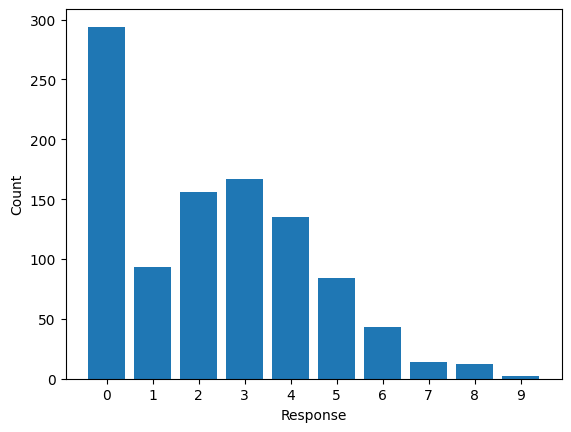

In [3]:
#| echo: false
values, counts = np.unique(x, return_counts=True)
fig, ax = plt.subplots()
ax.bar(values, counts)
ax.set(xlabel="Response", ylabel="Count", xticks=values);

### Create the `ZeroInflatedPoisson` Family

It comes one of the most important parts of the blogpost. If you care about creating new model families, this is what you need. Spoiler: it's so easy.

To create a model family, we first need to understand _what is_ a model family.

A family is defined by the combination of two objects

* A "likelihood" function which gives the probability distribution of the response
* A link function for the parameters in the likelihood function

* The name of the `Likelihood` must be the name of a valid PyMC distribution[^custom_likelihoods].
* `params` must be the names of the parameters in the corresponding PyMC distribution.
* `"log"` ang `"logit"` are built-in link functions so we can use their names and Bambi will handle the details. If we want a custom link function, we need to create a `bmb.Link` object manually.

In [4]:
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zero-inflated-poisson", likelihood, links)
zip_family

Family: zero-inflated-poisson
Likelihood: Likelihood(  
  name: ZeroInflatedPoisson,
  params: ['mu', 'psi'],
  parent: mu
)
Link: {'mu': Link(  
  name: log,
  link: <ufunc 'log'>,
  linkinv: <ufunc 'exp'>
), 'psi': Link(  
  name: logit,
  link: <function logit at 0x7f2dd0e6b880>,
  linkinv: <function expit at 0x7f2dd0e6b7f0>
)}

### Build and fit the model

* We need a priors for the `psi` parameter
* The formula for $\mu$ is an intercept-only model 

In [5]:
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}
model = bmb.Model("response ~ 1", df, family=zip_family, priors=priors)
model

       Formula: response ~ 1
        Family: zero-inflated-poisson
          Link: mu = log
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            response_psi ~ Beta(alpha: 3.0, beta: 3.0)

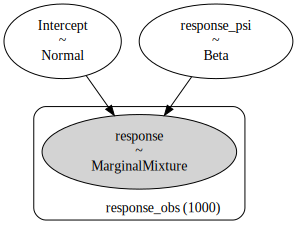

In [6]:
model.build()
model.graph()

In [7]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [response_psi, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


### Does the fit make sense?

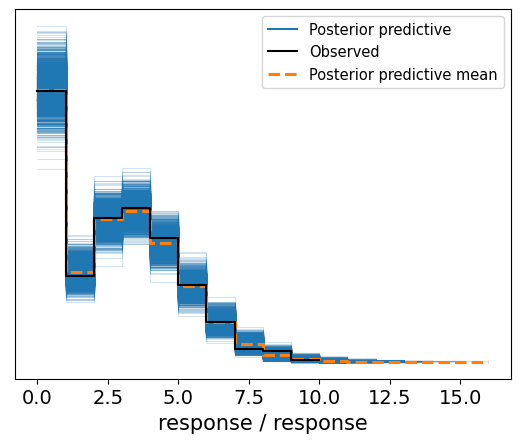

In [8]:
model.predict(idata, kind="pps")
az.plot_ppc(idata);

## A second example, now with a predictor

Both $\mu$ and $\psi$ change with the predictor.

### Simulate the data

In [9]:
rng = np.random.default_rng(121195)
x = np.sort(rng.uniform(0.2, 3, size=500))

b0, b1 = 0.1, 0.9
a0, a1 = 2.5, -0.7
mu = np.exp(b0 + b1 * x)
psi = expit(a0 + a1 * x)

y = pm.draw(pm.ZeroInflatedPoisson.dist(mu=mu, psi=psi))
df = pd.DataFrame({"y": y, "x": x})

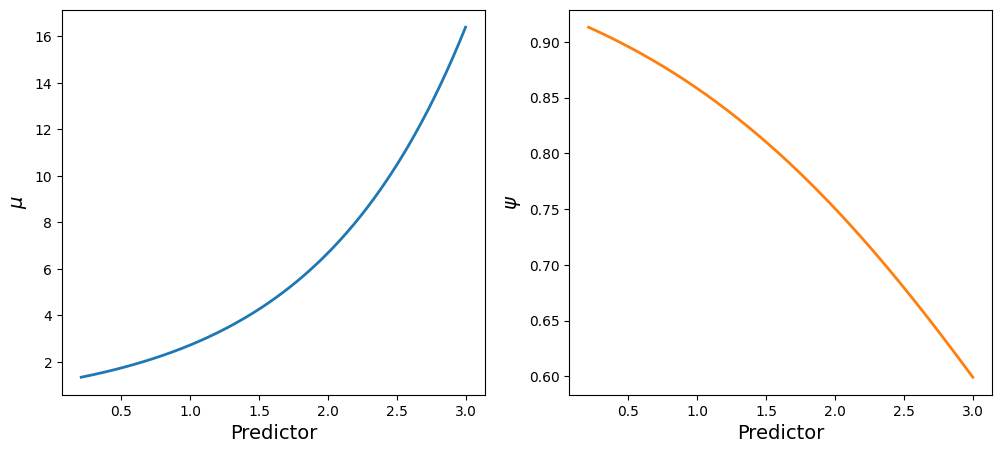

In [10]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, mu, lw=2)
axes[1].plot(x, psi, lw=2, color="C1")

axes[0].set_xlabel("Predictor", size=14)
axes[1].set_xlabel("Predictor", size=14)
axes[0].set_ylabel("$\\mu$", size=14)
axes[1].set_ylabel("$\\psi$", size=14);

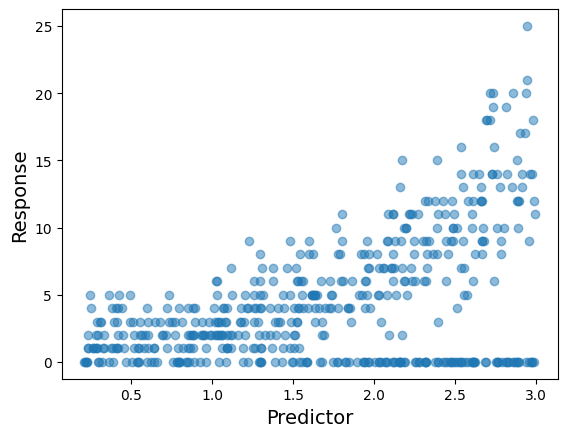

In [11]:
#| echo: false
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5);
ax.set_xlabel("Predictor", size=14)
ax.set_ylabel("Response", size=14);

### Build and fit the model (again)

Notice we don't need to create the family again. It's already there!

In [12]:
formula = bmb.Formula("y ~ x", "psi ~ x")
model = bmb.Model(formula, df, family=zip_family)
model

       Formula: y ~ x
                psi ~ x
        Family: zero-inflated-poisson
          Link: mu = log
                psi = logit
  Observations: 500
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.7833)
            x ~ Normal(mu: 0.0, sigma: 3.1083)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            psi_x ~ Normal(mu: 0.0, sigma: 1.0)

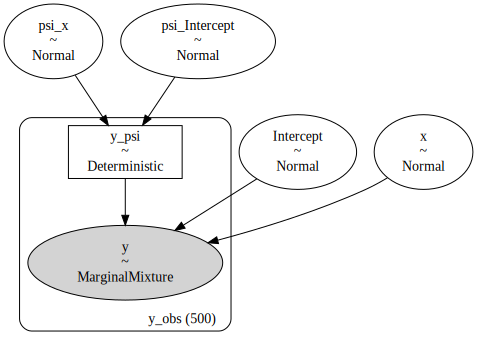

In [13]:
model.build()
model.graph()

In [14]:
idata = model.fit(random_seed=121195)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, psi_Intercept, psi_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


### Evaluate the inference

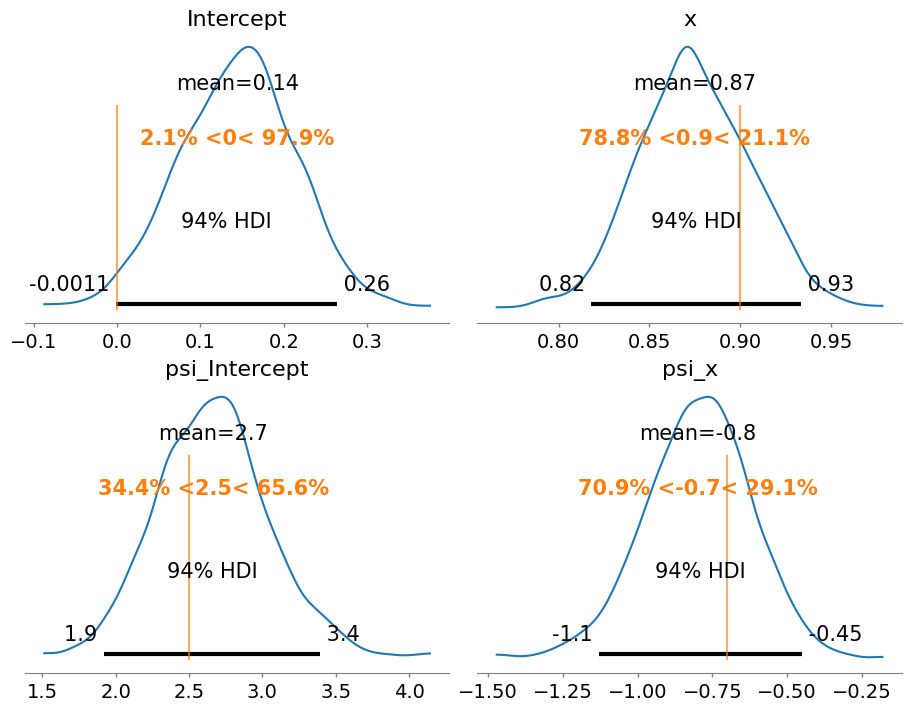

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7), layout="constrained")
az.plot_posterior(
    idata,
    var_names=["Intercept", "x", "psi_Intercept", "psi_x"], 
    ref_val=[0, 0.9, 2.5, -0.7],
    ax=axes
);

### Show-off Bambi a little more

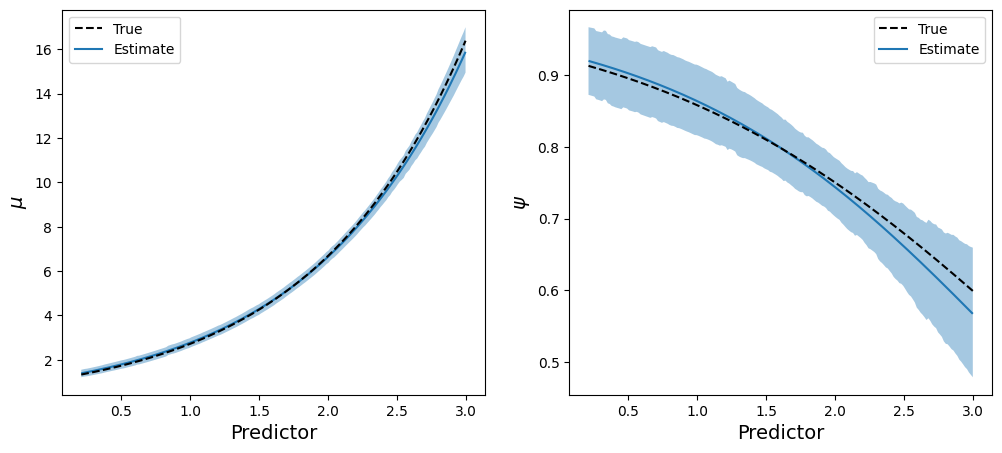

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_cap(model, idata, "x", ax=axes[0])
plot_cap(model, idata, "x", target="psi", ax=axes[1])

axes[0].plot(x, mu, color="black", ls="--")
axes[1].plot(x, psi, color="black", ls="--")

axes[0].set_xlabel("Predictor", size=14)
axes[1].set_xlabel("Predictor", size=14)
axes[0].set_ylabel("$\\mu$", size=14)
axes[1].set_ylabel("$\\psi$", size=14)


handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ("True", "Estimate")
axes[0].legend(handles, labels, loc="upper left")
axes[1].legend(handles, labels, loc="upper right");

## Conclusions

* Compute the posterior distribution of parameters of the response distribution using in-sample or out-of-sample data.
* Compute the posterior predictive distribution for in-sample or out-of-sample data.
* Out of the box visualizations to evaluate model fit.
* No need to write any PyMC code or low-level code.

## TL;DR

If you want a custom family you need 

* Create a Likelihood object
* Define one or more link functions
* Use them to instantiate a Family object

```python
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zero-inflated-poisson", likelihood, links)
```

[^latest_changes]: See the PR [#607](https://github.com/bambinos/bambi/pull/607)  
[^zip_wikipedia]: [https://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson](https://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson)  
[^custom_likelihoods]: Custom likelihood functions are also possible but we don't cover them here